In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
sheet_id = "1KGICaTvObgaS4aFhk85vmrnnV0DT5lv9wkyvY-InzTE"
worksheet_name = "Sheet1"


The code defines a Google Sheets ID (sheet_id) and a worksheet name (worksheet_name) for future reference

In [ ]:
!pip install --upgrade gspread
!pip install pandas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import andrews_curves
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import accuracy_score
from google.colab import auth
import gspread
from google.auth import default
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

path_train = '/content/drive/MyDrive/Data/train_data.csv'
train_df = pd.read_csv(path_train)

path_val = '/content/drive/MyDrive/Data/val_data.csv'
val_df = pd.read_csv(path_val)

Importing Libraries to set up the notebook, and getting the dataset ready to be used by the AI model.

In [ ]:
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
sh = gc.open_by_key(sheet_id)
sh.worksheets()
worksheet = sh.worksheet(worksheet_name)
worksheet.get_all_records()
df = pd.DataFrame(worksheet.get_all_records())

The code retrieves all records from the worksheet, and converts them into a pandas DataFrame (df).

In [ ]:
df

,Model,LR,factor,patience,Validation accuracy,Diabetes Accuracy
0,1,0.00100,0.1,5,90%,80%
1,2,0.00010,0.1,5,88%,91%
2,3,0.00010,0.9,10,87%,93%
3,4,0.00001,0.1,1,94%,69%
4,5,0.00200,0.5,5,87%,92%


In [ ]:
X = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
y = ['diabetes']

X_train = train_df[X]
print('X_train, our input variables:')
print(X_train.head())
print()

y_train = train_df[y]
print('y_train, our output variable:')
print(y_train.head())

X_train, our input variables:
    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level
0  36.0             0              0  17.06          4.0                  145
1  58.0             0              0  37.83          6.1                  159
2  43.0             0              0  39.20          5.0                  160
3  67.0             1              0  28.39          5.7                  159
4   5.0             0              0  27.32          6.0                   80

y_train, our output variable:
   diabetes
0         0
1         0
2         0
3         0
4         0


Setting up the model by mentioning which columns represent the input features and which column is the output label.

In [ ]:
from imblearn.over_sampling import ADASYN

Importing ADASYN

In [ ]:
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

In [ ]:
X_val = val_df[X]
y_val = val_df[y]

In [ ]:
scaler = StandardScaler()
X_adasyn_scaled = scaler.fit_transform(X_adasyn)
X_val_scaled = scaler.transform(X_val)

The code uses a StandardScaler to standardize the features of two datasets, X_adasyn and X_val. The fit_transform method scales the training data (X_adasyn), while the transform method scales the validation data (X_val) using the parameters learned from the training data.

In [ ]:
# Convert pandas DataFrames to PyTorch tensors
X_adasyn_tensor = torch.tensor(X_adasyn_scaled, dtype=torch.float32)
y_adasyn_tensor = torch.tensor(y_adasyn.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

The code converts the standardized datasets (X_adasyn_scaled, y_adasyn, X_val_scaled, y_val) into PyTorch tensors (X_adasyn_tensor, y_adasyn_tensor, X_val_tensor, y_val_tensor) with a specified data type of float32.

In [ ]:
class DiabetesPredictionModel(nn.Module):
    def __init__(self, input_size):
        super(DiabetesPredictionModel, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten()
        )

        # Calculate the output size of the convolutional layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, input_size)
            conv_output_size = self._get_conv_output_size(dummy_input)

        self.linear_stack = nn.Sequential(
            nn.Linear(conv_output_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
        )

    def _get_conv_output_size(self, x):
        x = self.conv_stack(x)
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.conv_stack(x)
        logits = self.linear_stack(x)
        return logits

The code defines a neural network model (DiabetesPredictionModel) using PyTorch's nn.Module. It consists of convolutional layers followed by batch normalization, ReLU activation, and max pooling. The convolutional layers are then flattened, and the output is passed through fully connected layers with ReLU activation, dropout, and a final linear layer for binary classification. The model is designed for predicting diabetes based on input data with a specified size.

In [ ]:
# Define custom dataset for training and testing
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

The code creates a PyTorch dataset class (DiabetesDataset) for managing input features (X) and labels (y). It includes methods for accessing individual items and obtaining the dataset's length.

In [ ]:
import os
from google.colab import files

In [ ]:
os.makedirs('/content/drive/MyDrive/Models', exist_ok=True)

In [ ]:
# Create data loaders for training and validation
adasyn_dataset = DiabetesDataset(X_adasyn_tensor.unsqueeze(1), y_adasyn_tensor)  # Add an extra dimension for input channels
val_dataset = DiabetesDataset(X_val_tensor.unsqueeze(1), y_val_tensor)  # Add an extra dimension for input channels
adasyn_loader = DataLoader(adasyn_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

The code sets up PyTorch datasets (adasyn_dataset and val_dataset) and corresponding data loaders (adasyn_loader and val_loader). The input features are adjusted to include an additional dimension for input channels using unsqueeze(1). The DataLoader is configured with batch sizes and optional shuffling for the training dataset.

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
import random

max_list_length = 10

# Define the run_model_experiment function
def run_model_experiment(experiment_number):
    # Generate random learning rate, factor, and patience values
    lr = random.uniform(1e-5, 1e-2)
    hyp1 = random.uniform(0.05, 0.9)
    hyp2 = random.randint(1, 10)

    # Instantiate the model
    input_size = X_adasyn_tensor.shape[1]
    model = DiabetesPredictionModel(input_size)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=hyp1, patience=hyp2, verbose=True)

    num_epochs = 5
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in adasyn_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            loss.backward()

            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(adasyn_dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets.squeeze())
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_dataset)

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'/content/drive/MyDrive/Models/model_{experiment_number}.pt')

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}")

    model.load_state_dict(torch.load(f'/content/drive/MyDrive/Models/model_{experiment_number}.pt'))

    model.eval()
    with torch.no_grad():
        y_pred_adasyn = (model(X_adasyn_tensor.unsqueeze(1)) > 0.5).squeeze().numpy()
        y_pred_val = (model(X_val_tensor.unsqueeze(1)) > 0.5).squeeze().numpy()

    val_accuracy = round(accuracy_score(y_val, y_pred_val) * 100, 1)

    # Calculate diabetes prediction accuracy
    cm_val = confusion_matrix(y_val, y_pred_val)

    diabetes_accuracy_val = round(cm_val[1][1] / (cm_val[1][1] + cm_val[1][0]) * 100, 1)

    print("Val Accuracy:", val_accuracy)

    print("Val Diabetes Accuracy:", diabetes_accuracy_val)

    # Format lr and accuracies for Google Sheets
    lr_str = "{:.2E}".format(lr)
    val_accuracy_str = str(val_accuracy) + '%'
    diabetes_accuracy_val_str = str(diabetes_accuracy_val) + '%'

    # Add experiment details to Google Sheets
    worksheet.append_row([experiment_number, lr_str, hyp1, hyp2, val_accuracy_str, diabetes_accuracy_val_str])

adasyn_loader = DataLoader(adasyn_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Run experiments
experiment_number = 71
for _ in range(max_list_length):
    run_model_experiment(experiment_number)
    experiment_number += 1


Epoch 1/5, Train Loss: 0.30, Val Loss: 0.30
Epoch 2/5, Train Loss: 0.28, Val Loss: 0.28
Epoch 3/5, Train Loss: 0.28, Val Loss: 0.29
Epoch 4/5, Train Loss: 0.28, Val Loss: 0.24
Epoch 5/5, Train Loss: 0.28, Val Loss: 0.31
Val Accuracy: 89.3
Val Diabetes Accuracy: 90.9
Epoch 1/5, Train Loss: 0.29, Val Loss: 0.24
Epoch 2/5, Train Loss: 0.28, Val Loss: 0.24
Epoch 3/5, Train Loss: 0.28, Val Loss: 0.29
Epoch 00004: reducing learning rate of group 0 to 1.9862e-03.
Epoch 4/5, Train Loss: 0.27, Val Loss: 0.28
Epoch 5/5, Train Loss: 0.27, Val Loss: 0.28
Val Accuracy: 89.4
Val Diabetes Accuracy: 86.5
Epoch 1/5, Train Loss: 0.30, Val Loss: 0.27
Epoch 2/5, Train Loss: 0.29, Val Loss: 0.34
Epoch 3/5, Train Loss: 0.28, Val Loss: 0.24
Epoch 4/5, Train Loss: 0.28, Val Loss: 0.29
Epoch 5/5, Train Loss: 0.28, Val Loss: 0.27
Val Accuracy: 87.7
Val Diabetes Accuracy: 90.2
Epoch 1/5, Train Loss: 0.29, Val Loss: 0.33
Epoch 2/5, Train Loss: 0.28, Val Loss: 0.29
Epoch 3/5, Train Loss: 0.28, Val Loss: 0.25
Epoch

The code defines a function (run_model_experiment) that runs a machine learning experiment with a randomized set of hyperparameters. It trains a diabetes prediction model using PyTorch, monitors validation loss, and saves the best model. The experiments are conducted multiple times, and the results, including accuracy metrics, are printed and stored in the Google Sheet.

In [ ]:
# Creating data loaders for training and validation
adasyn_dataset = DiabetesDataset(X_adasyn_tensor.unsqueeze(1), y_adasyn_tensor)
val_dataset = DiabetesDataset(X_val_tensor.unsqueeze(1), y_val_tensor)
adasyn_loader = DataLoader(adasyn_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Instantiating the model
input_size = X_adasyn_tensor.shape[1]
model = DiabetesPredictionModel(input_size)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=10, verbose=True)

The code prepares data loaders for training and validation using PyTorch. It creates instances of a diabetes prediction model, defines a loss function, sets up an optimizer, and incorporates a learning rate scheduler for training.

In [ ]:
#Training and testing model
num_epochs = 5
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in adasyn_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets.squeeze())
        loss.backward()

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(adasyn_dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_dataset)

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')  # Save the best model

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Loading the best model for predictions
model.load_state_dict(torch.load('best_model.pt'))


Epoch 1/5, Train Loss: 0.3380, Val Loss: 0.3116
Epoch 2/5, Train Loss: 0.2850, Val Loss: 0.2659
Epoch 3/5, Train Loss: 0.2738, Val Loss: 0.3047
Epoch 4/5, Train Loss: 0.2680, Val Loss: 0.2850
Epoch 5/5, Train Loss: 0.2642, Val Loss: 0.2852


<All keys matched successfully>

The code trains a diabetes prediction model for a specified number of epochs. It iterates through the training data, updates the model's weights based on the loss, and evaluates the model on the validation data. The best-performing model is saved. After training, the code loads the saved best model for making predictions.

In [ ]:
model.eval()
with torch.no_grad():
    y_pred_adasyn = (model(X_adasyn_tensor.unsqueeze(1)) > 0.5).squeeze().numpy()
    y_pred_val = (model(X_val_tensor.unsqueeze(1)) > 0.5).squeeze().numpy()

adasyn_accuracy = accuracy_score(y_adasyn, y_pred_adasyn)
val_accuracy = accuracy_score(y_val, y_pred_val)

print("ADASYN Accuracy:", adasyn_accuracy)
print("Val Accuracy:", val_accuracy)


ADASYN Accuracy: 0.8711915902047761
Val Accuracy: 0.8766


The code uses a trained model to predict outcomes for two datasets (ADASYN and validation). It calculates accuracy scores by comparing the model predictions to the actual labels and prints the accuracy for both datasets.

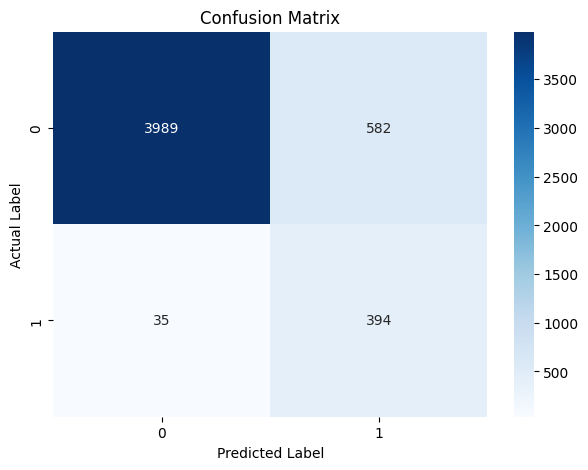

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred_val)

cm_df = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])

plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

The code computes a confusion matrix using the predicted values (y_pred_val) and actual labels (y_val). It then visualizes the confusion matrix using a heatmap, providing an overview of the model's performance in terms of true positives, true negatives, false positives, and false negatives.

In [ ]:
import pickle

# Save the model to a .h5 file using pickle
with open('/content/drive/MyDrive/Data/model.pkl', 'wb') as file:
    pickle.dump(DiabetesPredictionModel, file)


The code saves the diabetes prediction model as a serialized file (.pkl) using the pickle library. The serialized model can be later loaded and used for predictions.